In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.special import loggamma

In [20]:
df = pd.read_csv('SLS22.csv')

# 1 Uppvärmning. 
Följande uppgifter bör göra dig bekant med datamängden och förbereda data för användning när du bygger dina prediktiva modeller.

(a) Alla betyg i dataramen är för närvarande tal mellan 0 och 10. Normalisera dessa värden i dataramen så att de är mellan 0 och 1.

In [21]:
for col in df.columns:
    if df[col].dtype == np.float64:
        df[col] = df[col].apply(lambda x: x/10)

(b) Gör ett histogram för alla trickbetyg för trick 1−4. Vad observerar du? Finns det ett visst värde som dyker upp oftare än de andra? Om så är fallet, hur står detta värde i jämförelse med de andra?

<Axes: ylabel='Frequency'>

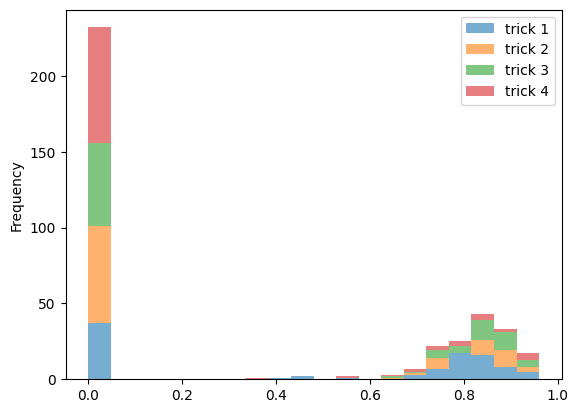

In [22]:
df[['trick 1', 'trick 2', 'trick 3', 'trick 4']].plot.hist(bins=20, stacked=True, alpha=0.6)

Svar: Det är tydligt att det absolut vanligaste talet är 0, dvs. att åkaren ej klarar trickcet.

(c) For varje trick 1−4 skapa en ny kolumn med namnet ’make i’ för i = 1, 2, 3, 4 så att värdet av ’make i’ i en given rad är 1 om skateboardåkaren landade trick i och 0 annars.

In [23]:
for i in range(1, 5):
    df[f"make {i}"] = df[f"trick {i}"].apply(lambda x: 1 if x > 0 else 0)

(d) För varje skateboardåkare skatta sannolikheten att ett trick får ett betyg som är större än 0.6 givet att skateboardåkaren landar tricket. Vad är sanno- likheten att skateboardåkaren inte lyckas landa ett visst trick? Vad observerar du? Relatera dina observationer till era observationer i del (b).

In [24]:
def compute_theta(group):
    total_tricks = 4 * len(group)
    passed_tricks = sum(group[f'make {i}'].sum() for i in range(1, 5))
    return pd.Series([total_tricks, passed_tricks, passed_tricks / total_tricks], index=['total', 'passed', 'theta'])

df_theta = df.groupby('id').apply(compute_theta).reset_index()
print(df_theta)

           id  total  passed     theta
0      Berger   12.0     2.0  0.166667
1     Decenzo   16.0     7.0  0.437500
2       Eaton    8.0     5.0  0.625000
3         Foy   12.0     6.0  0.500000
4        Fynn   12.0     6.0  0.500000
5     Gustavo   20.0     8.0  0.400000
6       Hoban   20.0     8.0  0.400000
7     Hoefler   16.0     7.0  0.437500
8    Horigome   16.0     9.0  0.562500
9      Huston    8.0     3.0  0.375000
10     Jordan   20.0     8.0  0.400000
11     Joslin   20.0     9.0  0.450000
12    Majerus    8.0     3.0  0.375000
13    McClung    4.0     1.0  0.250000
14     Midler   12.0     4.0  0.333333
15      Milou   20.0     9.0  0.450000
16       Mota   12.0     3.0  0.250000
17   Oliveira   12.0     5.0  0.416667
18    O’neill   12.0     3.0  0.250000
19       Papa   16.0     7.0  0.437500
20    Pudwill   12.0     3.0  0.250000
21  Ribeiro C   12.0     3.0  0.250000
22  Ribeiro G   24.0    13.0  0.541667
23  Rodriguez    8.0     4.0  0.500000
24   Santiago   12.0     

Svar: Om en skateboardare klarar tricket så får de nästan alltid ett betyg över 0.6. Detta ser man också i histogrammen.

(e) Gör ett spridningsdiagram för runbetyg 1 mot runbetyg 2. Ser du någon tydligt korrelation från diagrammet?

0.19053845069841102


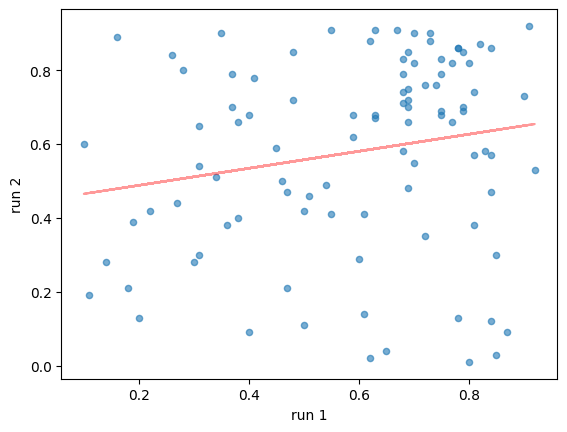

In [25]:
df.plot.scatter(x='run 1', y='run 2', alpha=0.6)
z = np.polyfit(df['run 1'], df['run 2'], 1)
p = np.poly1d(z)
ro = np.corrcoef(df['run 1'], df['run 2'])[0, 1]
plt.plot(df['run 1'],p(df['run 1']),"r-", alpha=0.4)
print(ro)
plt.show()

Svar: Väldigt svag positiv korrerlation, ro=0.19. Många värden verkar vara koncentrerade i övre högra hörnet, men annars är spridningen väldigt stor.

# 2. En frekventistisk modell.

(a) Ge en punktskattning för varje θi, sannolikheten att skateboardåkaren i landar ett trick.
θi = x_bar, dvs. theta från ovan

(b) Ge en punktskattning för parametrarna [αi,βi]T för varje skateboardåkare i. Finns det skateboardåkare för vilka din valda punktskattning inte existera? I så fall föreslå en alternativ punktskattning för dessa αi, βi. Motivera dina val punktskattningar.

In [26]:
def estimate_alpha_beta(scores):
    mean = scores.mean()
    var = scores.var()
    alpha = mean * (mean * (1 - mean) / var - 1)
    beta = (1 - mean) * (mean * (1 - mean) / var - 1)
    return alpha, beta

In [87]:
def compute_stats(group):
    total_tricks = 4 * len(group)
    passed_tricks = sum(group[f'make {i}'].sum() for i in range(1, 5))
    
    trick_scores = np.concatenate([group.loc[group[f'make {i}'] == 1, f'trick {i}'] for i in range(1, 5)])
    run_scores = np.concatenate([group[f'run {i}'] for i in range(1, 3)])
    
    theta = passed_tricks / total_tricks
    alpha_trick, beta_trick = estimate_alpha_beta(trick_scores) if len(trick_scores) >= 2 else (1, 1)
    alpha_run, beta_run = estimate_alpha_beta(run_scores) if len(run_scores) >= 2 else (1, 1)
    
    return pd.Series(
        [theta, alpha_trick, beta_trick, alpha_run, beta_run], 
        index=['theta', 'alpha_trick', 'beta_trick', 'alpha_run', 'beta_run']
    )

drop_cols = ["Horigome", "Joslin", "Milou", "Ribeiro G"]
frequentisc_model_params = df[~df["id"].isin(drop_cols)].groupby('id').apply(compute_stats)
print(frequentisc_model_params)

              theta  alpha_trick  beta_trick    alpha_run     beta_run
id                                                                    
Berger     0.166667   159.140000   58.860000     2.794278     4.591480
Decenzo    0.437500    24.455929    5.110825     4.164506     2.834664
Eaton      0.625000    75.408256   20.045233   103.573288    36.865068
Foy        0.500000    51.589516    9.104032     3.506609     4.088934
Fynn       0.500000    32.488000    6.812000     5.221980     5.582117
Gustavo    0.400000    70.644593   17.523386     1.228081     0.856946
Hoban      0.400000   107.698921   15.034892     3.632207     2.096826
Hoefler    0.437500    32.522583    9.403399     1.754494     0.965652
Huston     0.375000   142.310000   18.190000     6.328318     1.837254
Jordan     0.400000    23.062983    3.638010     3.608210     1.228533
Majerus    0.375000     2.912773    2.724852     1.755202     2.474200
McClung    0.250000     1.000000    1.000000  2585.790000  5892.210000
Midler

(d) Använd din modell för [Xi,Yi]T för att simulera 5000 LCQ:ar och för varje simulering extrahera de fyra skateboardåkare W = [W1,W2,W3,W4]^T med de högsta totalbetygen. Vad är typvärdet för W1, ... , W5000? De riktiga vinnarna för LCQ:en är Gustavo, Hoban, Eaton, Decenzo. Hur många av de riktiga vinnarna förutsägs av typvärdet? Vad är skattade sannolikheten för de riktiga vinnarna baserat på dina simuleringar? Av typvärdet?

In [28]:
results = []
for _ in range(5000):
    row_scores = {}
    for _, row in frequentisc_model_params.iterrows():
        score = 0
        
        # runs
        alpha, beta = row[f'alpha_run'], row[f'beta_run']
        for _ in range(1, 3):
            score += np.random.beta(alpha, beta)
        
        # tricks
        alpha, beta = row[f'alpha_trick'], row[f'beta_trick']
        for _ in range(1, 5):
            if np.random.uniform() < row['theta']:
                score += np.random.beta(alpha, beta)
        row_scores[row.name] = score
    results.append(row_scores)
scores_df = pd.DataFrame(results)

In [29]:
total_scores = scores_df.sum(axis=0)
total_scores.sort_values(ascending=False, inplace=True)
print('Highest total scores')
print(total_scores[0:4])

top_4 = scores_df.apply(lambda row: row.nlargest(4).index.tolist(), axis=1)
top_4 = [item for sublist in top_4 for item in sublist]
top_4 = pd.Series(top_4).value_counts()
print('\nMost frequent top 4')
print(top_4[0:4])

Highest total scores
Eaton     17317.795915
Suciu     16056.266190
Jordan    14482.350290
Huston    14456.279221
dtype: float64

Most frequent top 4
Eaton     2818
Suciu     2236
Jordan    1518
Huston    1489
Name: count, dtype: int64


# 3. En bayesiansk modell.

(a) Föreslå en simultan apriorifördelning för parametrarna [Θi , Ai , Bi ]T för Xi där vi antar Θi ⊥ Ai, Bi för alla i. Motivera ditt val.

$\Theta_{i} \perp\!\!\!\perp A_{i}, B_{i} \implies f_{\Theta_{i}, A_{i}, B_{i}}(\theta_{i}, \beta_{i}, \alpha_{i})=f_{\Theta_{i}}(\theta_{i}) f_{A_{i}, B_{i}}(\alpha_{i}, \beta_{i})$ och vi kan därmed behandla $\Theta_{i}$ och $A_{i}, B_{i}$ separat.

$Ber(\theta_{i})$ har som konjugerad apriorifördelning $Beta(a_{i}, b_{i})$, och vi kommer därmed använda den.

$Beta(\alpha_{i}, \beta_{i})$ har ingen konjugerad apriorifördelning, men med hjälp av samma knep som i Exempel 10.8 så kan vi få följande apriorifördelning:
$$
f_{A_{i}, B_{i}}(\alpha_{i}, \beta_{i}) = \frac{\lambda^{\phi_{i}}}{\Gamma(\phi_{i})} (\alpha_{i} + \beta_{i} + 1)^{\phi_{i} - 1} e^{-\lambda_{i}(\alpha_{i} + \beta_{i} + 1)} (\alpha_{i} + \beta_{i})^{-1}
$$
Sammansatt får vi följande funktion för den simultana apriorifördelningen:
$$
f_{\Theta_{i}, A_{i}, B_{i}}(\theta_{i}, \alpha_{i}, \beta_{i}) = (\frac{\Gamma(a_{i} + b_{i})}{\Gamma(a_{i}) \Gamma(b_{i})} \theta_{i}^{a_{i}-1} (1-\theta_{i})^{b_{i}-1}) (\frac{\lambda^{\phi_{i}}}{\Gamma(\phi_{i})} (\alpha_{i} + \beta_{i} + 1)^{\phi_{i} - 1} e^{-\lambda_{i}(\alpha_{i} + \beta_{i} + 1)} (\alpha_{i} + \beta_{i})^{-1})
$$
Vi kommer använda $a_{i}=b_{i}=1$, som val för en icke-informativ fördelning för $\Theta_{i}$. Vi väljer samma värden som i Exempel 10.8 för $A_{i}, B_{i}$, dvs $\lambda_{i}=1, \phi_{i}=3$.

(b) Generera 5000 slumpmässiga utfall från aposteriorifördelningen fθi,αi,βi|Xi (θi, αi, βi|xi).
Plotta dina resulterande utfall för de marginella aposteriorifördelningarna:
fθi|Xi (θi|xi) and fαi,βi|Xi (αi, βi|xi).
Beräkna det aposteriori stickprovsmedelvärdet och den aposteriori stickprov-
sorvariansen för varje parameter θi,αi, och βi för alla skateboardåkare.

Vi utnyttjar det faktum att $f_{\Theta | \mathbf{X}}(\theta | \mathbf{x}) \propto f_{\mathbf{X} | \Theta}(\mathbf{x} | \theta) f_{\Theta}(\theta)$ tillsammans med metropolisalgoritmen som har den trevliga egenskapen att $f$ ej måste vara normaliserad. 
#### du är inte klar här

In [49]:
def log_prior_trick(theta, alpha, beta, a = 1, b = 1, lamda = 1, phi = 3):
    return (a - 1) * np.log(theta) + (b - 1) * np.log(1 - theta) + (phi - 1) * np.log(alpha + beta + 1) - lamda*(alpha + beta + 1) - np.log(alpha + beta)

def log_posterior_trick(data, theta, alpha, beta, a = 1, b = 1, lamda = 1, phi = 3): # ignoring constants
    log_p = log_prior_trick(theta, alpha, beta, a, b, lamda, phi)
    
    for x in data:
        if x == 0:
            log_p += np.log(1 - theta)
        else:
            log_p += np.log(theta) + loggamma(alpha + beta) - loggamma(alpha) - loggamma(beta) + (alpha - 1) * np.log(x) + (beta - 1) * np.log(1 - x)

    return log_p
        

In [45]:
whole_model_params = compute_stats(df)
print(whole_model_params)

theta           0.402062
alpha_trick    11.614200
beta_trick      2.638594
alpha_run       1.929261
beta_run        1.368330
dtype: float64


In [46]:
tricks = np.concatenate([df[f'trick {i}'] for i in range(1, 5)])

In [72]:
def metropolis_algorithm(data, log_posterior_func, n_samples, proposal_sd, start_params):
    # Initialize the chain with the starting parameters
    current_params = start_params
    current_log_posterior = log_posterior_func(data, *current_params)

    samples = np.empty((n_samples, len(start_params)))
    for i in range(n_samples):
        proposed_params = [np.exp(np.log(param) + proposal_sd[i] * np.random.normal(0, 1, 1)[0]) for i, param in enumerate(current_params)]
        proposed_params[0] = min(1-1e-6, proposed_params[0])
        
        proposed_log_posterior = log_posterior_func(data, *proposed_params)

        acceptance_prob = min(1, np.exp(proposed_log_posterior - current_log_posterior))

        # Accept or reject the proposal
        if np.random.uniform() < acceptance_prob:
            current_params = proposed_params
            current_log_posterior = proposed_log_posterior

        samples[i] = current_params

    return samples

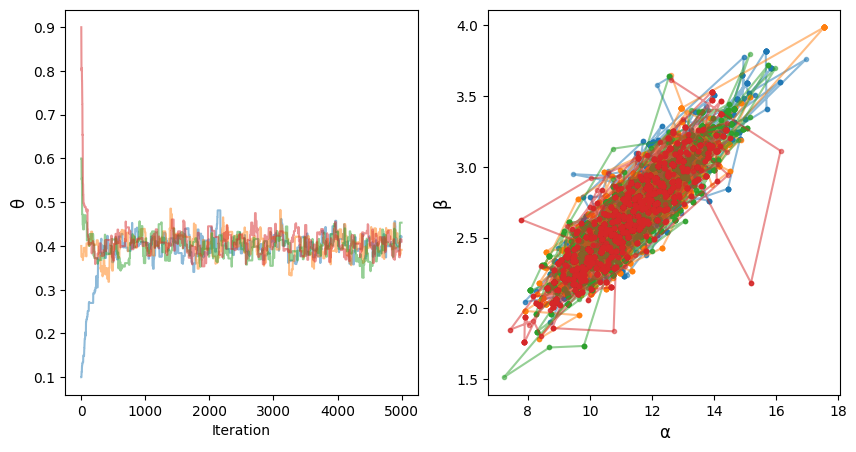

In [81]:
n_chains = 4
n_samples = 5000
proposal_sd = [0.05, 0.3, 0.3]
theta_start = [0.1, 0.4, 0.6, 0.9]
alpha_start = whole_model_params['alpha_trick'] + np.exp(stats.cauchy.rvs(size=n_chains, scale=0.05))
beta_start = whole_model_params['beta_trick'] + np.exp(stats.cauchy.rvs(size=n_chains, scale=0.05))

samples_list = []
for i in range(n_chains):
    samples = metropolis_algorithm(tricks, log_posterior_trick, n_samples, proposal_sd, [theta_start[i], alpha_start[i], beta_start[i]])
    samples_list.append(samples)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('θ', fontsize=12)
axs[1].set_xlabel('α', fontsize=12)
axs[1].set_ylabel('β', fontsize=12)

for i in range(n_chains):
    thetas, alphas, betas = samples_list[i].T
    axs[0].plot(thetas, alpha=0.5, label=f'Chain {i + 1}')
    axs[1].plot(alphas, betas, '.-', alpha=0.5, label=f'Chain {i + 1}')

In [99]:
n_samples = 5000
proposal_sd = [0.05, 0.3, 0.3]

drop_cols = ["Horigome", "Joslin", "Milou", "Ribeiro G"]
gdf = df[~df["id"].isin(drop_cols)].groupby('id')

samples_dict = {}
for name, group in gdf:
    theta_start = frequentisc_model_params.loc[name, 'theta']
    alpha_start = frequentisc_model_params.loc[name, 'alpha_trick']
    beta_start = frequentisc_model_params.loc[name, 'beta_trick']
    
    tricks = np.concatenate([group[f'trick {i}'] for i in range(1, 5)])
    samples_dict[name] = metropolis_algorithm(tricks, log_posterior_trick, n_samples, proposal_sd, [theta_start, alpha_start, beta_start])

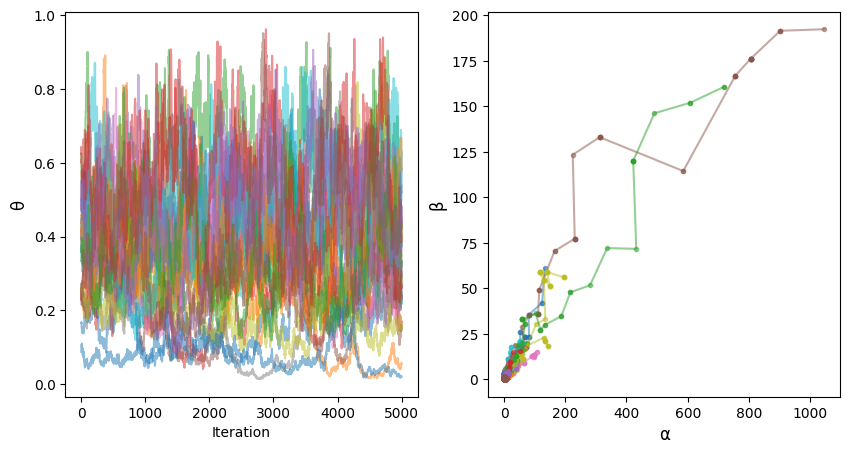

In [100]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('θ', fontsize=12)
axs[1].set_xlabel('α', fontsize=12)
axs[1].set_ylabel('β', fontsize=12)

for name, samples in samples_dict.items():
    thetas, alphas, betas = samples.T
    axs[0].plot(thetas, alpha=0.5, label=name)
    axs[1].plot(alphas, betas, '.-', alpha=0.5, label=name)

In [104]:
# make df of sample mean and variance for each parameter for each skater. only want to look at samples after burn-in
samples_df = pd.DataFrame(columns=['theta_mean', 'theta_var', 'alpha_mean', 'alpha_var', 'beta_mean', 'beta_var'])
for name, samples in samples_dict.items():
    thetas, alphas, betas = samples.T
    samples_df.loc[name] = [thetas[100:].mean(), thetas[100:].var(), alphas[100:].mean(), alphas[100:].var(), betas[100:].mean(), betas[100:].var()]
print(samples_df)

           theta_mean  theta_var  alpha_mean  alpha_var  beta_mean  beta_var
Berger       0.183676   0.007883    0.992113   0.843374   0.567455  0.227917
Decenzo      0.405735   0.012634    2.787083   2.046568   0.844712  0.153245
Eaton        0.547209   0.025394    1.917383   1.556139   0.737397  0.175934
Foy          0.493057   0.019636    2.369614   2.275979   0.718627  0.136450
Fynn         0.469261   0.017200    2.566343   2.231574   0.824271  0.167566
Gustavo      0.383055   0.010032    3.175491   3.027184   1.074465  0.265149
Hoban        0.383254   0.011227    3.514864   3.034672   0.822484  0.112972
Hoefler      0.383141   0.010114    2.742112   2.103814   1.055879  0.214642
Huston       0.361890   0.018993    1.601768   1.813146   0.504073  0.116788
Jordan       0.397232   0.007115    3.260751   2.709469   0.805306  0.117413
Majerus      0.373929   0.018669    0.792079   0.423557   0.682057  0.303767
McClung      0.289697   0.037277    0.131772   0.122496   0.121953  0.120984